In [615]:
import numpy as np
from random import random
from functools import reduce
from collections import namedtuple
from queue import PriorityQueue, SimpleQueue, LifoQueue
import matplotlib.pyplot as plt

In [616]:
# constants
PROBLEM_SIZE = 5   # dimension of the finite set U
NUMBER_SET = 10     # number of subsets in the collection S

State = namedtuple('State', ['taken','not_taken'])


In [617]:
def goal_check(state,sets):
    """
    check if the logical OR all the elements yeald a line of all true ie the
    condition for a state to be covering the whole set U
    """
    return np.all(reduce(np.logical_or, [sets[i] for i in state.taken], np.zeros(PROBLEM_SIZE)))


In [618]:
def solve(queuetype, steps, sets):
    """
    Solve the Set Covering problem using different queuing strategies.

    Args:
        queuetype (str): The type of queue to use. Supported values are 'priority', 'simple', or 'lifo'.
        steps (list): A list to store the number of iterations required to solve the problem.
        sets (tuple): A collection of subsets for the Set Covering problem.

    Returns:
        None: The function updates the 'steps' list with the number of iterations needed.
    """
    # Initialize the queue based on 'queuetype'
    if queuetype == "priority":
        frontier = PriorityQueue()
    elif queuetype == "simple":
        frontier = SimpleQueue()
    elif queuetype == "lifo":
        frontier = LifoQueue()

    # Create the initial state representing an empty set of selected subsets
    initial_state = State(set(), set(range(NUMBER_SET)))
    frontier.put(initial_state)

    counter = 0
    while not frontier.empty():
        counter += 1

        # Get the current state from the queue
        current_state = frontier.get()

        # Check if the current state is a solution
        if goal_check(current_state, sets):
            steps.append(counter)
            return

        # Generate successor states by taking actions (adding subsets)
        for action in current_state.not_taken:
            new_state = State(
                current_state.taken ^ {action}, current_state.not_taken ^ {action}
            )
            frontier.put(new_state)

    # Update the steps list
    steps.append(counter)

    counter = 0


In [619]:
# number of steps for a solution to be found
pq_steps = []
sq_steps = []
lfq_steps = []

N_RUNS = 1000

for i in range(N_RUNS):

    # generate sets in S
    sets = tuple(
        np.array([random() < 0.3 for i in range(PROBLEM_SIZE)])
        for j in range(NUMBER_SET)
    )  

    # assert generated problem is solvable, ie the goal check of a stete with all
    # sets taken is true -> around 85% it is solvable
    if goal_check(State(range(NUMBER_SET), 0), sets):
        solve("priority",pq_steps, sets)
        solve("simple",sq_steps, sets)
        solve("lifo",lfq_steps, sets)


In [620]:
# average number of steps for each queue type
pq_mean = np.mean(pq_steps)
sq_mean = np.mean(sq_steps)
lfq_mean = np.mean(lfq_steps)

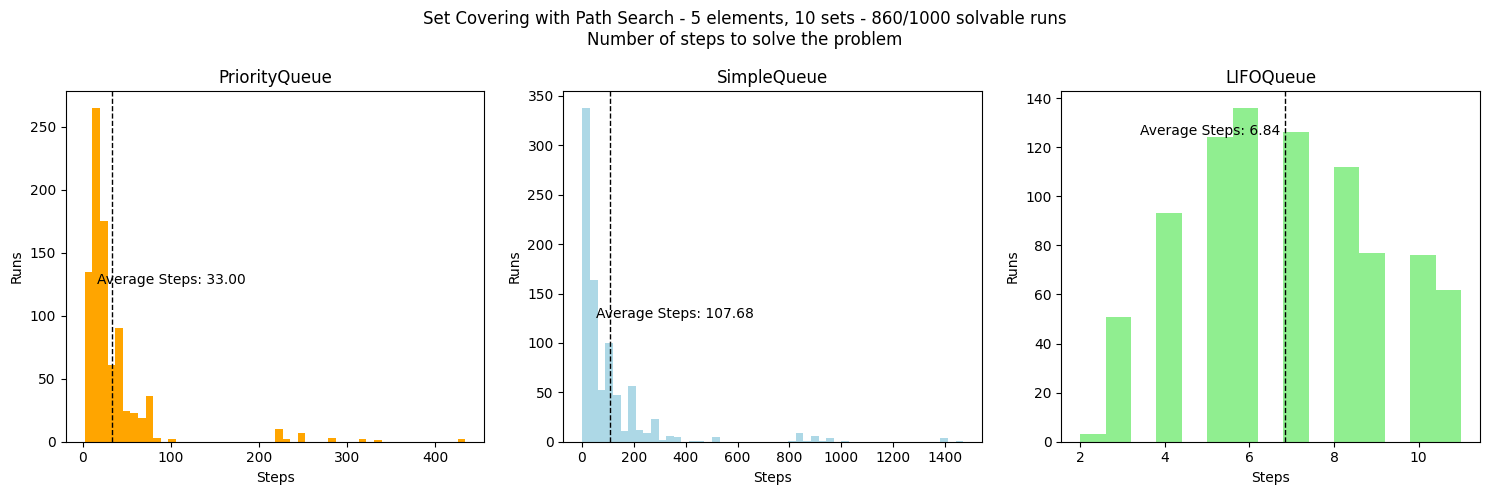

In [621]:
# Create a figure with three subplots in a single row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle(
    f"Set Covering with Path Search - {PROBLEM_SIZE} elements, {NUMBER_SET} sets - {len(pq_steps)}/{N_RUNS} solvable runs\nNumber of steps to solve the problem"
)

# pq
axs[0].hist(pq_steps, bins=50, color="orange")
axs[0].axvline(pq_mean, color="k", linestyle="dashed", linewidth=1)
axs[0].text(pq_mean / 2, N_RUNS / 8, "Average Steps: {:.2f}".format(pq_mean))
axs[0].set_title(f"PriorityQueue")
axs[0].set_ylabel("Runs")
axs[0].set_xlabel("Steps")

# sq
axs[1].hist(sq_steps, bins=50, color="lightblue")
axs[1].axvline(sq_mean, color="k", linestyle="dashed", linewidth=1)
axs[1].text(sq_mean / 2, N_RUNS / 8, "Average Steps: {:.2f}".format(sq_mean))
axs[1].set_title(f"SimpleQueue")
axs[1].set_ylabel("Runs")
axs[1].set_xlabel("Steps")

# ligoq
axs[2].hist(lfq_steps, bins=15, color="lightgreen")
axs[2].axvline(lfq_mean, color="k", linestyle="dashed", linewidth=1)
axs[2].text(lfq_mean / 2, N_RUNS / 8, "Average Steps: {:.2f}".format(lfq_mean))
axs[2].set_title(f"LIFOQueue")
axs[2].set_ylabel("Runs")
axs[2].set_xlabel("Steps")

plt.tight_layout()
plt.show()


In [622]:
# max number of combinations should be 2^10=1024 hoevever the number of steps
# for sq in some runs is much greater ?????????????????????????
print([i for i in filter(lambda x: x > 1024, sq_steps)])


[1401, 1470, 1406, 1406, 1390]


In [623]:
# per chatgpt:
# The number of steps can exceed the total number of combinations in the search
# space for certain algorithms and search strategies. This situation can occur for
# several reasons:

# Redundant States: In some search algorithms, it's possible to revisit or explore
# states that have already been considered. These redundant states can increase
# the number of steps without necessarily expanding the search space.

# Exploration Order: The order in which states are explored can affect the number
# of steps. If the algorithm explores less promising states first, it may take
# longer to find the solution, potentially exceeding the number of combinations.

# Inefficient Exploration: Inefficient exploration strategies or heuristics can
# lead to a higher number of steps. For example, if the algorithm frequently
# explores states that don't lead to the goal, it can result in more steps.

# Maximum Step Limit: In some implementations, a maximum step limit may be set to
# prevent infinite searching in unsolvable instances. If the algorithm reaches
# this limit without finding a solution, the number of steps can exceed the total
# number of combinations.

# It's important to note that the total number of combinations represents a
# theoretical upper bound on the number of possible states in the search space.
# The actual number of steps taken by an algorithm can vary based on the specific
# problem instance, the search strategy, and the efficiency of the algorithm.

# In the case of the Simple Queue, where states are explored in a straightforward
# First-In-First-Out (FIFO) order, it is less likely that the number of steps will
# significantly exceed the total number of combinations in the search space.
# Simple Queue explores states in a linear, sequential manner without specific
# prioritization or heuristic guidance.

# If the number of steps significantly exceeds the total number of combinations,
# it's more likely due to other factors, such as inefficient exploration order,
# redundant state exploration, or maximum step limits.


# The solve function you provided explores the search space systematically, and
# it should not, in theory, exceed the total number of combinations if it is
# implemented correctly. However, there are certain situations where it might
# seem like the Simple Queue is taking more steps than expected:

# Inefficient Exploration Order: The Simple Queue explores states in a first-in,
# first-out (FIFO) order. If the most promising states are not explored early,
# it can take more steps to find the solution.

# Redundant State Exploration: If there is an issue with state tracking, it
# could revisit states that have already been explored, increasing the step
# count.

# Maximum Step Limit: If a maximum step limit is set and the algorithm reaches
# this limit without finding a solution, it can result in a step count that
# seems excessive.

# Complexity of the Problem Instance: The complexity of the specific Set
# Covering problem instance can also affect the number of steps. Some instances
# might require more exploration due to the nature of the problem itself.
